<h4 align='right'> $\textit{Aurélien Castre, Eliott Tourtois}$ </h4>
<h1 align='center'> $\textbf{Filtrage - MACS207b}$ </h1>
$\newline$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import signal
from sklearn.cluster import KMeans

$\textbf{Question 1}$

$\tau$ suit une loi exponentielle de paramètre $\mu$, on peut donc facilement calculer $h$ :

$$ h(s)=\frac{f(s)}{1-F(s)}= \left\{
    \begin{array}{ll}
        \frac{\mu\exp(-\mu s)}{\exp(-\mu s)} & \mbox{si } s \in \mathbb{R}_+ \\
        0 & \mbox{sinon.}
    \end{array}
\right. = \mu \mathbb{1}_{\mathbb{R}_+}(s) $$

$\textbf{Question 2}$

Pour simuler $N$ sur l'intervalle de temps $[0, T]$, on commence par tirer $\tau$ selon une loi exponentielle de paramètre $\mu$. Ensuite, on tire les instants de saut de $N_a$ selon une loi exponentielle de paramètre $a$ en partant de 0 et tant qu'on ne dépasse pas la valeur de $\tau(\omega)$. Enfin, on tire les instants de saut de $N_b$ selon une loi exponentielle de paramètre $b$ en partant de $\tau(\omega)$ et tant qu'on ne dépasse pas $T$.

In [3]:
def N(a, b, mu = 0.2, end = 10, rng = np.random.default_rng(None)) :
    """Simulate the trajectory of N between 0 and T

    Parameters
    ----------
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    mu : float, optional
        The parameter of the exponential distribution of tau
    end : float, optional
        The end of the simulation
    rng : Generator, optional
        A Random Number Generator for reproducibility
        (default is np.random.default_rng(None))

    Returns
    -------
    float
        The value of tau in the simulation
    list
        The list of arrival times of the Poisson process before tau
    list
        The list of arrival times of the Poisson process after tau
        (empty if tau > T)
    """
    
    # Simulate tau using inverse transform sampling
    u = rng.uniform()
    tau = -1/mu*np.log(u)
    
    # Simulate the first Poisson process
    Tas = []
    t = 0
    while t <= min(tau, end) :
        u = rng.uniform()
        t += -1/a*np.log(u)
        Tas.append(t)
    Tas.pop()
    
    # Simulate the second Poisson process
    Tbs = []
    t = tau
    while t <= end :
        u = rng.uniform()
        t += -1/b*np.log(u)
        Tbs.append(t)
    # Pop the last arrival time (which might be greater that T) only
    # if Tbs is not empty (which is the case when tau > T)
    if Tbs:
        Tbs.pop()
        
    return tau, Tas, Tbs

In [4]:
def plotN(tau, Tas, Tbs, end = 10, z_estimate = None, kmeans_estimate = None) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float, optional
        The end of the simulation
    z_estimate : float, optional
        Plots the estimated value of tau using Z
        (defaults is None)
    kmeans_estimate : tuple, optional
        Plots the estimated interval of tau using kmeans
        (defaults is None)
    """
    
    T = Tas + Tbs
    plt.figure(figsize = (16,6))
    plt.step([0] + T + [end], [0] + [i for i in range(len(T) + 1)], label=r'$N(t)$')
    
    if tau <= end:
        plt.vlines(tau, 0, len(T) + 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=r'$\tau \approx $' + str(tau)[:4])
    
    if kmeans_estimate :
        plt.fill_betweenx(np.linspace(0,len(T) + 1), kmeans_estimate[0], kmeans_estimate[1], alpha = 0.2,\
                          color = 'g', label = "kmeans estimate")
    if z_estimate :
        plt.vlines(z_estimate, 0, len(T) + 1, color='g', label=r'$\hat{\tau} \approx $' + str(z_estimate)[:4])
    
    plt.legend(loc = 'right', fontsize = 18)
    plt.xticks(range(end + 1))
    plt.grid()

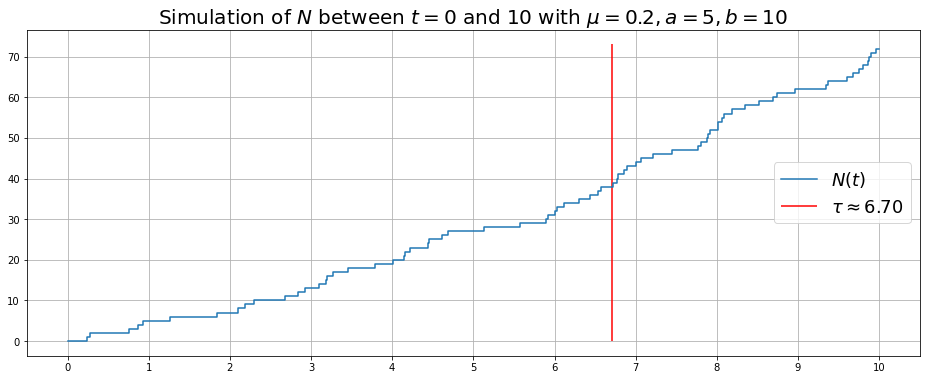

In [4]:
seed = 2
rng = np.random.default_rng(seed)
a = 5
b = 10

tau, Tas, Tbs = N(a, b, rng=rng)
plotN(tau, Tas, Tbs)
plt.title(rf"Simulation of $N$ between $t = 0$ and {10} with $\mu = {0.2}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

$\textbf{Question 3}$

### Calcul de $\hat Z$

Pour calculer $\hat Z$, on utilise le résultat de la question 10 de l'exercice 2.2 du polycopié, *i.e.*
$$\hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t \left(h(s) - (b-a)\hat{Z}(s)\right)\left(1-\hat{Z}(s)\right)\mathrm{d}s$$

On remarque qu'en dehors des instants de sauts, $\hat Z$ est $\mathcal{C}^1$. On peut donc dériver l'équation ci-dessus pour obtenir l'équation différentielle ci-dessous que nous résoudrons numériquement entre chaque instant de saut :
$$\frac{\mathrm{d}}{\mathrm{d}t}\hat{Z}(t) = \left(\mu - (b-a)\hat{Z}(t)\right)\left(1-\hat{Z}(t)\right)$$

Quant à la valeur aux instants de sauts, elle est donnée par la formule
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a)\hat{Z}(T_n^-)\left(1-\hat{Z}(T_n^-)\right)}{a + (b-a)\hat{Z}(T_n^-)}$$

Pour approximer $\hat{Z}(T_n^-)$, on choisira simplement le dernier point de la simulation numérique qui précède le saut.

Dans la suite du code, `Z` désignera $\hat Z$.

In [5]:
def Z(a, b, T, mu = 0.2, end = 10, num = 50) :
    """Computes an approximation of the conditional expectation Z(t) for
    all t between 0 and T

    Parameters
    ----------
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    T : list
        The arrival times of N
    mu : float, optional
        The parameter of the exponential distribution of tau
    end : float, optional
        The end of the simulation
    num : int, optional
        The number of points used to approximate Z between any two arrival times
        (default is 50)

    Returns
    -------
    list
        The list of points used to plot Z (linspaces + arrival times)
    numpy array
        1D array of values of Z
    """

    dZ = lambda y, t : (mu - (b - a)*y)*(1 - y)
    z = [0]
    ts = []
    for i in range(len(T) - 1):
        t = np.linspace(T[i], T[i+1], num)[:-1]
        ts += list(t)
        # Solve the differential equation between two points
        z = np.append(z, odeint(dZ, z[-1], t).flatten())
        zjump = (b-a)*z[-1]*(1 - z[-1])/(a + (b-a)*z[-1])
        # Add the jump
        z = np.append(z, zjump + z[-1])
        ts.append(T[i+1])

    return ts, z[1:]

In [6]:
def plotZ(ts, z, tau, end = 10) :
    """Plots the graph of the process Z"""
    
    plt.figure(figsize = (16,6))
    plt.plot(ts, z, label=r'$\hatZ (t) = \mathbb{E}\left[\mathbb{1}_{\tau \leq t}|\mathcal{F}^N_t\right]$')
    plt.xticks(range(end + 1))
    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    plt.legend(fontsize = 15)
    plt.grid()

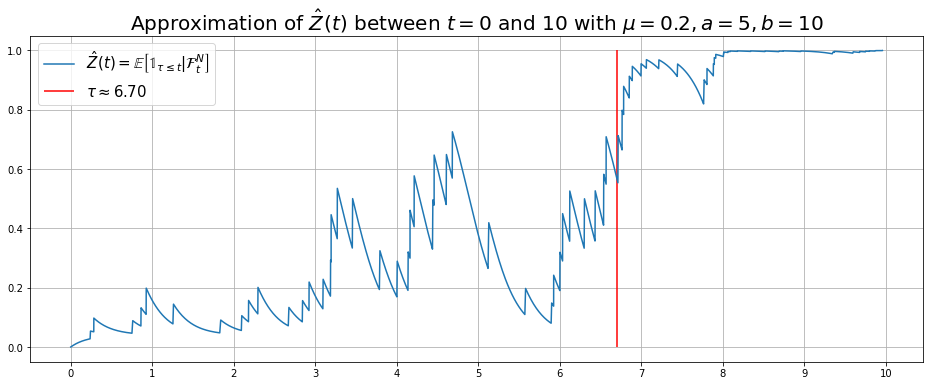

In [12]:
T = [0] + Tas + Tbs
ts, z = Z(a, b, T)

plotZ(ts, z, tau)
plt.title(rf"Approximation of $\hatZ (t)$ between $t = 0$ and {10} with $\mu = {0.2}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

Le résultat est intuitif : avant $\tau$ on observe des aspérités liées au caractère aléatoire des données mais aucun stabilité, après $\tau$ en revanche la pente se fait plus franche et 1 unité de temps plus tard on obtient un résultat quasi constant à 1.

$\textbf{Remarque :}$ on a volontairement cherché une courbe de $\hat Z$ pour laquelle il n'est pas facile d'obtenir une estimation de $\tau$ afin de faciliter le calibrage des paramètres pour la suite de la question.

### Estimation de $\tau$

Il faut ensuite calculer l'approximation de $\tau$. Pour cela, nous proposons une méthode en deux temps.
- Il faut d'abord lisser la courbe de $\hat{Z}$ pour ignorer les sauts ainsi que les erreurs qui peuvent être commises du fait du caractère aléatoire des données (par malchance, on peut avoir beaucoup de sauts rapprochés avant $\tau$, ce qui conduirait à une augmentation abrupte de $\hat{Z}$). L'objecif est de se rapprocher de l'allure d'une sigmoïde ou d'une indicatrice.
- Ensuite, il faut choisir l'abscisse qui approximera le mieux $\tau$. Nous proposons deux idées :
    - fixer un seuil déterminé expérimentalement et mesurer le premier dépassement de ce seuil par la courbe lissée,
    - ou dériver la coubre lissée et choisir l'abscisse du maximum.
    
Dans la suite de la réponse, on définira une méthode d'évalutation pour ensuite choisir la meilleure technique d'approximation. Commençons d'abord par tester différent filtres sur la courbe de $\hat{Z}$ choisie pour être particulièrement mauvaise.

In [7]:
def zfilter(z, name) :
    """Returns the filtered version of z"""
    
    if name == 'hamming' :
        window = signal.hamming(800)
        zfiltered = signal.filtfilt(window, 1, z)
        return zfiltered/np.max(zfiltered)
    if name == 'butterworth' :
        d, c = signal.butter(1, 0.001)
        return signal.filtfilt(d, c, z)
    if name == 'savgol' :
        return signal.savgol_filter(z, 801, 1)
    else :
        print("Wrong filter name.")

In [8]:
def plotZfiltered(ts, z, tau, name, end = 10):
    """Plots the filtered version of z"""
    
    plt.figure(figsize = (16,4))
    zfiltered = zfilter(z,name)
    plt.plot(ts, zfiltered, label=rf"${name}\left[\hatZ (t)\right]$")
    plt.title(rf"Filtering of $\hatZ (t)$ between $t = 0$ and {end} using ${name}$ filter", fontsize = 18)
    plt.xticks(range(end + 1))
    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

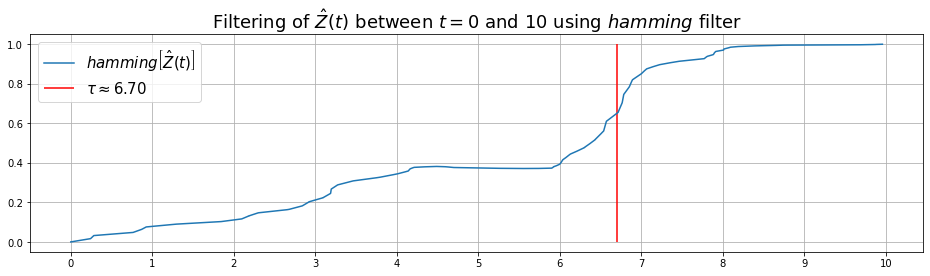

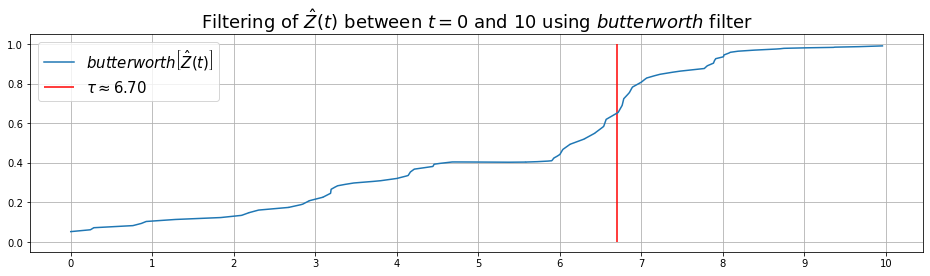

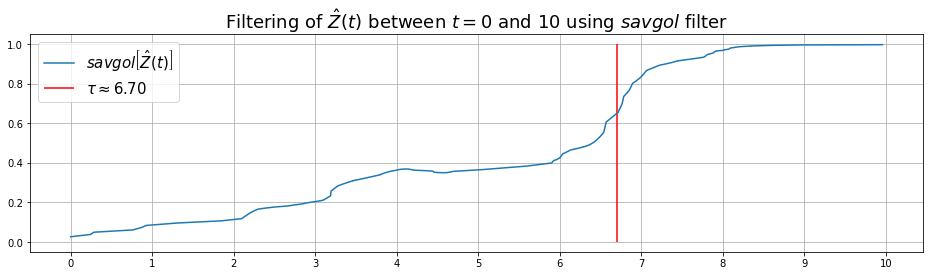

In [15]:
plotZfiltered(ts,z,tau,'hamming')
plotZfiltered(ts,z,tau,'butterworth')
plotZfiltered(ts,z,tau,'savgol')

Il s'agit maintenant de tester ces différents filtres sur beaucoup de données simulées.

In [9]:
def treshold_estimate(ts, zfiltered, tresh) :
    """Returns an estimation of tau using the last 2 times (at most) where Z crosses the treshold while going up"""
    
    times = []
    for i in range(len(zfiltered)) :
        if ((zfiltered[i] > tresh) and (zfiltered[i-1] <= tresh)):
            times.append(ts[i])
    if len(times) > 1:
        return (times[-1] + times[-2])/2
    else :
        return(times[0])

In [10]:
def evaluate_treshold(zfilter_name, n, a, b, tresh = 0.5, end = 10, rng = np.random.default_rng(None)) :
    """Returns an estimation of the error of the approximation using the treshold method"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 : # avoid cases where tau >= 10
            # we simulate to 2*end to make sure we have enough points for our approximation
            tau, Tas, Tbs = N(a, b, end=2*end, rng=rng)
        ts, z = Z(a, b, [0] + Tas + Tbs, end=2*end)
        zfiltered = zfilter(z, zfilter_name)
        htau = treshold_estimate(ts, zfiltered, tresh)
        error += np.abs(htau - tau)
    return error/n

In [11]:
def evaluate_gradient(zfilter_name, n, a, b, end = 10, rng = np.random.default_rng(None)) :
    """Returns an estimation of the error of the approximation using the derivative method"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, end=2*end, rng=rng)
        ts, z = Z(a, b, [0] + Tas + Tbs, end=2*end)
        zfiltered = zfilter(z, zfilter_name)
        htau = ts[np.argmax(np.gradient(zfiltered))]
        error += np.abs(htau - tau)
    return error/n

In [21]:
%%timeit
print(evaluate_treshold('butterworth', 10, 5, 10))

0.8627830796347578
1.0925860149349595
1.1442538793456027
0.5714083719888252
0.6979730870783483
0.7548928364516226
0.7477714397453529
0.6156216116891176
458 ms ± 67.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
print(evaluate_treshold('hamming', 10, 5, 10))

1.2475442849570524
1.544029213926969
0.8353888313842097
1.1446657489222614
0.4824978158318888
1.1675897842777825
1.0033331023310557
0.8531574717254008
804 ms ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
print(evaluate_treshold('savgol', 10, 5, 10))

0.9195422227168312
0.899361110728994
1.2722791563629356
1.1550579688042635
0.9670671406311966
1.1634803700777738
1.0947841231635675
1.2911175388004303
599 ms ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On peut voir ici que le filtrage *butterworth* est le plus rapide en moyenne mais que l'algorithme de Savitzky-Golay s'effectue en un temps comparable. En revanche le filtrage par fenêtre de Hamming est beaucoup plus lent. Pour une seule exécution cela reste raisonnable mais pour les tests statistiques que nous souhaitons effectuer par la suite cela risque de poser problème.

Pour correctement comparer les méthodes, il nous faut maintenant déterminer le seuil optimal. Commençons par une rapide analyse qualitative afin de déterminer un intervalle plus restreint sur lequel faire nos tests.

In [12]:
def test_tresholds(low, high, step, name, n, a, b, rng = np.random.default_rng(None)):
    """Returns all the errors for a given filter and given tresholds"""
    
    tresholds = np.arange(low, high, step)
    errors = []
    for tresh in tresholds :
        errors.append(evaluate_treshold(name, n, a, b, tresh = tresh, rng=rng))
    return(errors, tresholds, tresholds[np.argmin(errors)])

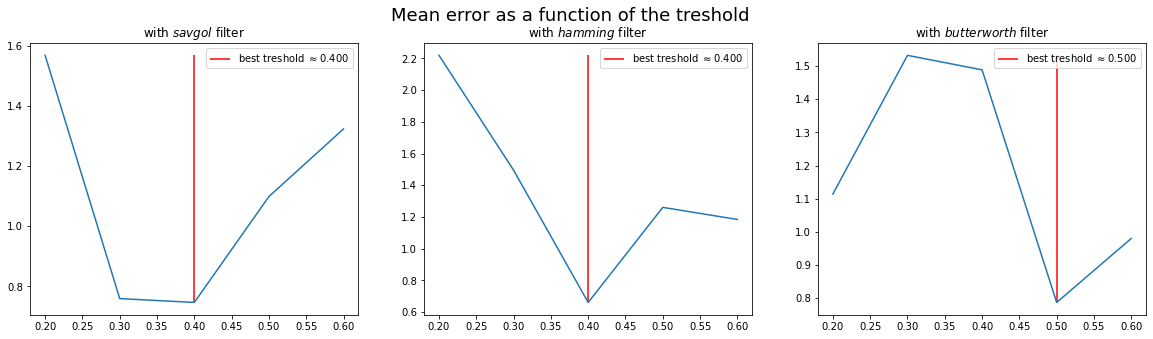

In [143]:
low = 0.2
high = 0.7
step = 0.1
names = ['savgol','hamming','butterworth']
n = 10
a = 5
b = 10
rng = np.random.default_rng(2)

besttresholds = []
f, axs = plt.subplots(1,3,figsize=(20, 5))
f.suptitle("Mean error as a function of the treshold", fontsize = 18)
for i,ax in zip([0,1,2],axs):
    name = names[i]
    errors, tresholds, besttresh = test_tresholds(low, high, step, name, n, a, b, rng=rng)
    besttresholds.append((name,besttresh))
    ax.plot(tresholds,errors)
    ax.vlines(besttresh,min(errors),max(errors),color='r',label=rf"best treshold $\approx $" + str(besttresh)[:5])
    ax.legend()
    ax.set_title(rf"with ${name}$ filter", fontsize = 12)

Il semble que le meilleur seuil se situe entre 0.3 et 0.6, on peut donc affiner notre analyse.
$\textbf{Attention, la cellule qui suite met beaucoup de temps à s'exécuter.}$

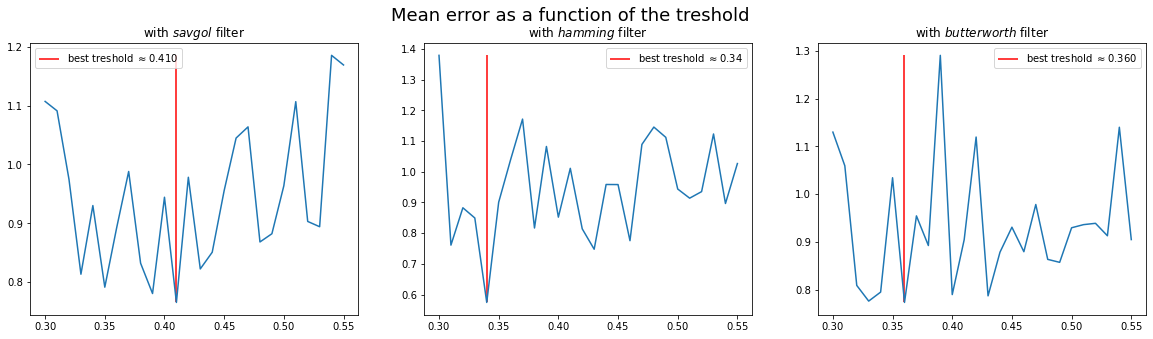

In [144]:
low = 0.3
high = 0.55
step = 0.01
names = ['savgol','hamming','butterworth']
n = 50
a = 5
b = 10
rng = np.random.default_rng(2)

besttresholds = []
f, axs = plt.subplots(1,3,figsize=(20, 5))
f.suptitle("Mean error as a function of the treshold", fontsize = 18)
for i,ax in zip([0,1,2],axs):
    name = names[i]
    errors, tresholds, besttresh = test_tresholds(low, high, step, name, n, a, b, rng=rng)
    besttresholds.append((name,besttresh))
    ax.plot(tresholds,errors)
    ax.vlines(besttresh,min(errors),max(errors),color='r',label=rf"best treshold $\approx $" + str(besttresh)[:5])
    ax.legend()
    ax.set_title(rf"with ${name}$ filter", fontsize = 12)

### Calcul des scores finaux

In [156]:
n = 100
rng = np.random.default_rng(2)

evaluate_treshold('hamming', 10, 5, 10)
savgolgrad = evaluate_gradient('savgol', n, a, b, rng=rng)
hamminggrad = evaluate_gradient('hamming', n, a, b, rng=rng)
buttergrad = evaluate_gradient('butterworth', n, a, b, rng=rng)
savgoltresh = evaluate_treshold('savgol', n, a, b, tresh=besttresholds[0][1], rng=rng)
hammingtresh = evaluate_treshold('hamming', n, a, b, tresh=besttresholds[1][1], rng=rng)
buttertresh = evaluate_treshold('butterworth', n, a, b, tresh=besttresholds[2][1], rng=rng)
scores = [savgolgrad,savgoltresh,hamminggrad,hammingtresh,buttergrad,buttertresh]

In [163]:
print("Savgol filter :\nderivative method:",scores[0],"\ntreshold method",scores[1])
print("\nHamming filter :\nderivative method:",scores[2],"\ntreshold method",scores[3])
print("\nButterworth filter :\nderivative method:",scores[4],"\ntreshold method",scores[5])

Savgol filter :
derivative method: 1.2004486436241695 
treshold method 0.9075227163706089

Hamming filter :
derivative method: 1.1888037436700045 
treshold method 0.8482374767584777

Butterworth filter :
derivative method: 1.175724366874529 
treshold method 0.9387299486396223


Il apparaît clairement que la méthode du seuil est la meilleure, affinons un peu plus nos résultats sur un autre générateur de nombres aléatoires.

In [166]:
n = 1000
rng = np.random.default_rng(3)

evaluate_treshold('butterworth', n, a, b, besttresholds[2][1], rng=rng)

0.9380314001285861

In [167]:
n = 1000
rng = np.random.default_rng(3)

evaluate_treshold('savgol', n, a, b, tresh=besttresholds[0][1], rng=rng)

0.9658556187927619

Compte tenu de son efficacité, nous choisirons le filtre *butterworth* pour les comparaisons de la question 5.

$\textbf{Question 4}$

Pour approximer $\tau$ en utilisant l'algorithme kmeans, on va d'abord appliquer une méthode naïve. On fait tourner l'algorithme sur la liste des instants de saut pour les séparer en 2 clusters. Ensuite, on approxime tau par la moyenne des deux instants de saut qui se situent à la frontière. On utilisera kmeans++ pour initialiser notre algorithme (ainsi, on s'assure que les deux premiers instants soient suffisamment éloignés pour espérer qu'ils tombent dans $N_a$ et dans $N_b$) et on répète l'algorithme 10 fois (`n_init = 10`).

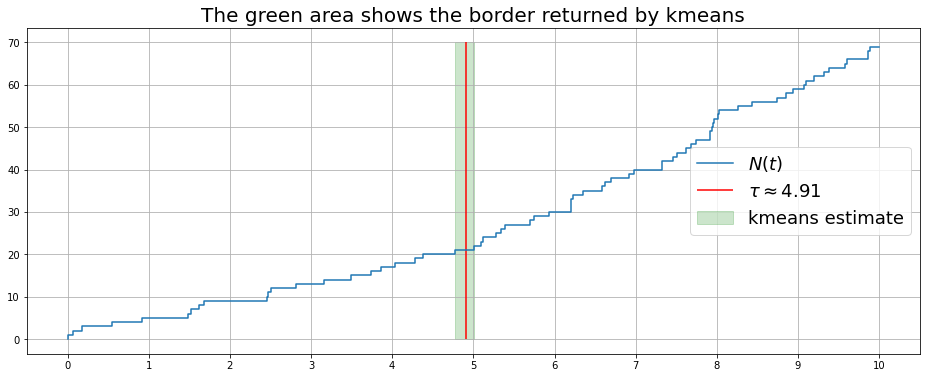

In [25]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

# Generate N again with a RandomState generator this time (required for kmeans implementation in scipy)
tau, Tas, Tbs = N(a, b, rng=rng)
T = [0] + Tas + Tbs

points = np.array(T).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
pred = kmeans.predict(points)
p = abs((1-pred[0])-pred) # make sure 1's are before 0's
plotN(tau, Tas, Tbs, kmeans_estimate = (T[p.sum()-1], T[p.sum()]))
plt.title("The green area shows the border returned by kmeans", fontsize = 20)
plt.show()

Le graphe ci-dessus suggère que cette méthode naïve pourrait s'avérer assez efficace. Evaluons maintenant ses performances de façon plus rigoureuse.

In [13]:
def evaluate_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using naive kmeans"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [51]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_kmeans(100, a, b, rng = rng)

2.8733964466881816

Les résultats sont en fait moins bon que ce que suggérait l'exemple, nous avons donc essayé de changer l'initialisation de l'algorithme en prenant en compte la valeur de $\mu$. En effet, celle-ci est utilisée dans l'approximation donnée par $\hat{Z}$, il est donc naturel de s'en autoriser la connaissance ici aussi.

In [14]:
def evaluate_kmeans_mu_init(n, a, b, mu = 0.2, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using kmeans with custom init"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        
        T = [0] + Tas + Tbs
        m = np.mean(T)
        def mu_init(X, n_clusters, random_state) :
            X = X.flatten() + m
            i = len([x for x in X if x < 1/mu])
            return [X[random_state.randint(i, len(X))]-m], [X[random_state.randint(0, i)]-m]
        
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=10, init=mu_init, random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [28]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_kmeans_mu_init(1000, a, b, rng = rng)

2.8496733896162443

La différence est minime et la méthode déterministe consistant à prendre le premier et le dernier élément des données comme pour initialiser l'algorithme s'avère non seulement plus rapide mais aussi équivalente en précision, comme le démontrent les cellules qui suivent.

In [15]:
def evaluate_deter_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using kmeans with deterministic init"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        
        def deter_init(X, n_clusters, random_state) :
            X = X.flatten()
            return [X[0]], [X[-1]]
        
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=1, init=deter_init, random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [189]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_deter_kmeans(1000, a, b, rng=rng)

2.754947766680835

Pour essayer d'améliorer l'algorithme, une autre idée nous est venue à l'esprit. Celle-ci provient de la remarque que kmeans en une dimension n'est pas un algorithme très efficace : il risque de quasiment toujours couper au milieu. On pourrait donc essayer de trouver des fonctions des instants de sauts qui changent à $\tau$ et les ajouter à la valeur des instants de sauts pour créer des points en plusieurs dimensions.

Si on se donne un processus de poisson stationnaire alors il est possible d'approximer :
- son intensité en calculant $\frac{N(t)}{t}$ quand $t$ devient grand,
- l'inverse de son intensité en calculant la moyenne des temps d'inter-arrivées.

On va exploiter ces deux approximations pour créer un ensemble de points en trois dimensions.

In [31]:
rate_approx = []
for i in range(1, len(T)) :
    rate_approx.append(i/T[i])
rate_approx = np.array(rate_approx)
rate_approx

array([98.92825983, 27.58432609, 17.13133112,  7.31697905,  5.44507749,
        4.03378992,  4.61690164,  4.94449154,  5.33490186,  4.05902258,
        4.45387817,  4.78767477,  4.61590347,  4.43417938,  4.28999885,
        4.28438615,  4.40020671,  4.46500967,  4.44124962,  4.57004146,
        4.40226207,  4.39060835,  4.51936898,  4.69355872,  4.73978771,
        4.86799729,  5.00615544,  4.91202451,  5.04336405,  5.06156716,
        4.99977781,  5.15669734,  5.31484885,  5.45721018,  5.51253963,
        5.46964946,  5.58936003,  5.67013227,  5.64225843,  5.72868123,
        5.60154205,  5.7307225 ,  5.76091156,  5.86254987,  5.90409042,
        5.98396241,  6.06639656,  6.06334962,  6.18725532,  6.29328428,
        6.41411162,  6.53075128,  6.61362154,  6.73157374,  6.65506503,
        6.64502693,  6.52400811,  6.55422646,  6.59678374,  6.61216241,
        6.70847738,  6.74202986,  6.7574765 ,  6.82002671,  6.78491148,
        6.87348148,  6.79392704,  6.89440613,  6.97751045])

Si l'on ignore les 3 premières valeurs on voit que l'approximation est plutôt bonne : l'intensité empirique tend assez vite vers 5 puis, un peu après le dépassement de $\tau$ elle se remet à croître. Cela devrait donc accentuer la séparation des points autour de $\tau$.

In [32]:
interarrival_approx = []
parsum = 0
for i in range(1, len(T)) :
    parsum += T[i] - T[i - 1]
    interarrival_approx.append(parsum/i)
interarrival_approx = np.array(interarrival_approx)
interarrival_approx

array([0.01010834, 0.03625247, 0.05837258, 0.13666842, 0.18365212,
       0.24790582, 0.21659547, 0.20224526, 0.18744487, 0.24636473,
       0.22452343, 0.20886966, 0.21664231, 0.22552087, 0.2331003 ,
       0.23340567, 0.22726205, 0.22396368, 0.22516185, 0.2188164 ,
       0.22715595, 0.22775887, 0.22126983, 0.21305795, 0.21097991,
       0.20542329, 0.19975408, 0.20358205, 0.19828035, 0.19756727,
       0.20000889, 0.19392257, 0.18815211, 0.18324381, 0.18140459,
       0.18282707, 0.17891136, 0.17636273, 0.17723399, 0.17456025,
       0.17852227, 0.17449807, 0.17358364, 0.17057424, 0.1693741 ,
       0.16711335, 0.1648425 , 0.16492534, 0.16162255, 0.15889954,
       0.15590624, 0.15312174, 0.15120309, 0.14855367, 0.15026149,
       0.15048848, 0.15328001, 0.15257331, 0.15158902, 0.15123645,
       0.14906512, 0.14832328, 0.14798424, 0.14662699, 0.14738586,
       0.14548668, 0.14719028, 0.14504513, 0.14331759])

Ici encore, le résultat est plutôt prometteur : on tend relativement vite vers 0.2 puis on continue de diminuer après $\tau$. Codons maintenant une fonction permettant de facilement générer les points en 3D en fonction des instants de saut.

In [33]:
def points_3D(T) :
    """Returns a numpy array of points in 3D to be classified by kmeans"""
    
    rate_approx = []
    interarrival_approx = []
    parsum = 0
    for i in range(1, len(T)) :
        parsum += T[i] - T[i - 1]
        interarrival_approx.append(parsum/i)
        rate_approx.append(i/T[i])
    T = np.array(T[1:])
    interarrival_approx = np.array(interarrival_approx)
    rate_approx = np.array(interarrival_approx)
    return np.column_stack((T, interarrival_approx, rate_approx))

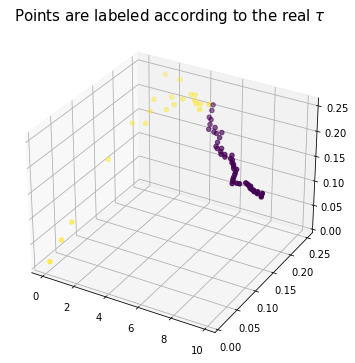

In [34]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# Computing the real labels of the points
labels = []
for i in range(1, len(T)) :
    if T[i] < tau :
        labels.append(1)
    else :
        labels.append(0)

points = points_3D(T)
ax.scatter(points.T[0], points.T[1], points.T[2], c=labels)
plt.title(rf"Points are labeled according to the real $\tau$", fontsize = 15)
plt.show()

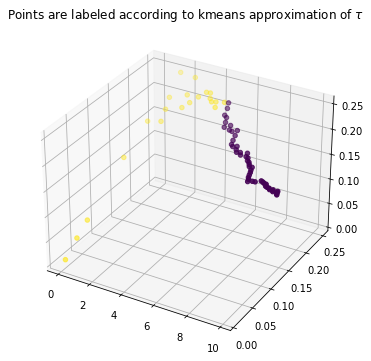

In [40]:
seed = 42
rng = np.random.RandomState(seed)

kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state = rng).fit(points)
pred = kmeans.predict(points)
p = abs((1-pred[0])-pred)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(points.T[0], points.T[1], points.T[2], c=p)
plt.title(rf"Points are labeled according to kmeans approximation of $\tau$", fontsize = 12)
plt.show()

Ici encore, la technique semble tout à fait prometteuse : la classification des points est bien réalisée par kmeans. Mettons la à l'épreuve d'une évaluation plus rigoureuse.

In [42]:
def evaluate_3D_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using 3D-kmeans"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = points_3D(T)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred) 
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [86]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_3D_kmeans(1000, a, b, rng = rng)

2.768916272423207

Le résultat est une fois de plus très déçevant et le gain minime ! Nous avons alors essayé une dernière idée : ajouter deux dimensions de plus correspondant aux dérivées discrètes des approximations introduites plus tôt tout en enlevant les premières valeurs qui faussent la classification. L'idée derrière les dérivées est la même qu'à la question précédente : il s'agit d'accentuer la cassure qui se passe dans le voisinage de $\tau$.

In [41]:
def points_5D(T, a, burn_in = 2) :
    """Returns a numpy array of points in 5D to be classified by kmeans"""
    
    rate_approx = []
    interarrival_approx = []
    parsum = 0
    for i in range(1, len(T)) :
        parsum += T[i] - T[i - 1]
        interarrival_approx.append(parsum/i)
        rate_approx.append(i/T[i])
    T = np.array(T[1:])
    interarrival_approx = np.array(interarrival_approx)
    rate_approx = np.array(interarrival_approx)
    
    # Avoiding the first values
    for i in range(burn_in) :
        interarrival_approx[i] = np.mean(interarrival_approx[2:2*a])
        rate_approx[i] = np.mean(rate_approx[2:2*a])
    
    # Computing the discrete derivatives
    dinterarrival_approx = np.insert(interarrival_approx[1:] - np.roll(interarrival_approx, 1)[1:], 0, interarrival_approx[0])
    drate_approx = np.insert(rate_approx[1:] - np.roll(rate_approx, 1)[1:], 0, rate_approx[0])
    
    return np.column_stack((T, rate_approx, interarrival_approx, drate_approx, dinterarrival_approx))

In [43]:
def evaluate_5D_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    """Returns an estimation of the error of the approximation using 5D-kmeans"""
    
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = points_5D(T, a)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [93]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_5D_kmeans(1000, a, b, rng = rng)

2.768916272423207

Cette fois il semble que le résultat ait été le même qu'en 3D sur 1000 échantillons différents, on peut donc conclure une fois de plus que cette technique n'apporte pas d'amélioration.

En conclusion, le meilleur compromis entre rapidité d'exécution, simplicité et précision semble être la version déterministe de kmeans en une dimension. C'est celle que nous utiliserons pour la comparaison dans la question suivante.

$\textbf{Question 5}$

Les questions précédentes montrent que la précision de la méthode de la question 3 est largement meilleure que la méthode kmeans pour $a=5$ et $b=10$. Pour étudier la robustesse de ces méthodes nous nous concentrerons sur l'écart entre $a$ et $b$, car c'est cela qui rend difficile (ou aisé) l'estimation de $\tau$ à l'oeil nu.

### Robustesse

In [16]:
seed = 42
rng = np.random.RandomState(seed)
n = 2
m = 100

la = np.arange(1, m, 2)
lb = m - la
z_errors = []
kmeans_errors = []
step = []
for i in range(len(la)//2, len(la)) :
    kmeans_errors.append(evaluate_deter_kmeans(n, lb[i], la[i], rng=rng))
    z_errors.append(evaluate_treshold('butterworth', n, lb[i], la[i], 0.36, rng=rng))
    step.append(np.abs(la[i] - lb[i]))

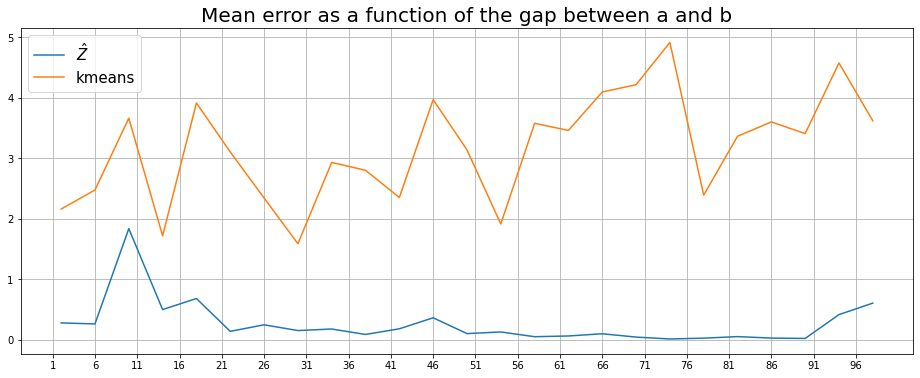

In [333]:
plt.figure(figsize=(16,6))
plt.plot(step, z_errors, label = r'$\hatZ$')
plt.plot(step, kmeans_errors, label = 'kmeans')
plt.legend(fontsize = 15)
plt.grid()
plt.xticks(np.arange(1, m, 5))
plt.title("Mean error as a function of the gap between a and b", fontsize = 20)
plt.show()

Ce graphe confirme les résultats des questions précédentes : la méthode de la quesion 3 est bien meilleure. On observe également un résultat qui va à l'encontre de notre intuition : l'erreur pour kmeans ne baisse pas lorsque l'écart entre $a$ et $b$ devient grand. Par contre, c'est bien le cas pour la méthode de la question 3. L'importante variance des résultats est dûe au fait que l'on n'effectue que deux passages pour chaque estimation, du fait du temps de calcul trop important.

### Modification du modèle d'arrivée

Pour changer le modèle d'arrivée, on va utiliser la généralisation de la loi exponentielle : la loi Gamma. On tirera toujours $\tau$ selon une exponentielle de paramètre $\mu$ mais cette fois les inter-arrivées seront tirées selon des lois Gamma de paramètres $(k_a,t_a)$ et $(k_b, t_b)$ respectivement.
Ainsi, le couple $(a = 5, b = 10)$ correspond à $((k_a = 1,t_a = 0.2)$, $(k_b = 1,t_b = 0.1))$.

In [274]:
def N_g(ka, ta, kb, tb, mu = 0.2, end = 10, rng = np.random.default_rng(None)) :
    
    # Simulate tau using inverse transform sampling
    u = rng.uniform()
    tau = -1/mu*np.log(u)
    
    # Simulate the first process
    Tas = []
    t = 0
    while t <= min(tau, end) :
        t += rng.gamma(ka, ta)
        Tas.append(t)
    Tas.pop()
    
    # Simulate the second process
    Tbs = []
    t = tau
    while t <= end :
        t += rng.gamma(kb, tb)
        Tbs.append(t)
    # Pop the last arrival time (which might be greater that T) only
    # if Tbs is not empty (which is the case when tau > T)
    if Tbs:
        Tbs.pop()
        
    return tau, Tas, Tbs

On choisit les valeurs $((k_a = 10,t_a = 0.02)$, $(k_b = 5,t_b = 0.02))$ afin de modifier significativement le modèle sans pour autant changer l'espérance des inter-arrivées.

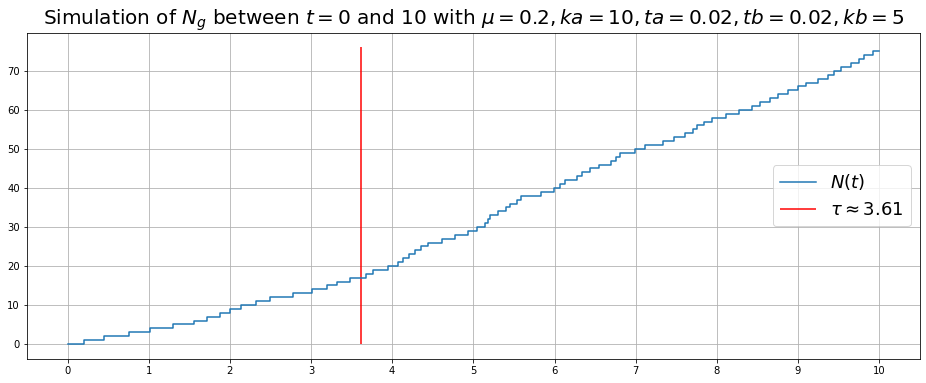

In [279]:
seed = 38
rng = np.random.default_rng(seed)
ka = 10
ta = 0.02
kb = 5
tb = 0.02

tau, Tas, Tbs = N_g(ka, ta, kb, tb, rng=rng)
plotN(tau, Tas, Tbs)
plt.title(rf"Simulation of $N_g$ between $t = 0$ and {10} with $\mu = {0.2}, ka = {ka}, ta = {ta}, tb = {tb}, kb = {kb}$", fontsize = 20)
plt.show()

In [288]:
def gamma_evaluate_deter_kmeans(n, ka, ta, kb, tb, rng = np.random.RandomState(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N_g(ka, ta, kb, tb, rng = rng)
        T = [0] + Tas + Tbs
        
        def deter_init(X, n_clusters, random_state) :
            X = X.flatten()
            return [X[0]], [X[-1]]
        
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=1, init=deter_init, random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

Pour approximer $\tau$ avec la méthode de la question 3, on considérera que $a = \frac{1}{t_a}$ et que $b = \frac{1}{t_b}$.

In [356]:
def gamma_evaluate_treshold(zfilter_name, n, ka, ta, kb, tb, tresh = 0.5, end = 10, rng = np.random.default_rng(None)) :
    """Returns an estimation of the error of the approximation using the treshold method"""
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 : # avoid cases where tau >= 10
            # we simulate to 2*end to make sure we have enough points for our approximation
            tau, Tas, Tbs = N_g(ka, ta, kb, tb, end=2*end, rng=rng)
        ts, z = Z(1/ta, 1/tb, [0] + Tas + Tbs, end=2*end)
        zfiltered = zfilter(z, zfilter_name)
        htau = treshold_estimate(ts, zfiltered, tresh)
        error += np.abs(htau - tau)
    return error/n

In [365]:
seed = 38
rng = np.random.RandomState(seed)
ka = 10
ta = 0.02
kb = 5
tb = 0.02
n = 100

print("Z estimation error : ", gamma_evaluate_treshold('butterworth', n, ka, ta, kb, tb, besttresholds[2][1], rng=rng))
print("kmeans estimation error : ", gamma_evaluate_deter_kmeans(n, ka, ta, kb, tb, rng=rng))

Z estimation error :  2.099292439504302
kmeans estimation error :  3.0676299181907205


On constate que la méthode de la question 3 résiste mal à une modification du modèle d'arrivée. L'erreur de la méthode kmeans reste à peu près la même, et se trouve toujours au-dessus de celle de la méthode de la question 3.

### Conclusion

La méthode de la question 3 permet non seulement d'obtenir une meilleure précision que la méthode kmeans mais elle permet aussi de mieux expliquer les résultats. En effet, $\hat Z(t)$ est une bonne modélisation de la confiance que l'on accorde au dépassement de $\tau$, ou non, à l'instant $t$, et il est donc aisé de motiver le choix d'un seuil pour l'estimation.

Par ailleurs, la précision de l'estimation par la méthode de la question 3 pourrait être considérablement amélioré si, à $\tau$ tiré et fixé, on générait un grand nombre de trajectoires différentes. Les erreurs liées au caractère aléatoire des données se compenseraient en réalisant une simple moyenne des estimations pour chaque trajectoire.